# Example of Anomaly Detection

Written by Seulki Kim (As of August 14, 2021)

Example is gotten from [Anomaly Detection in Time Series Sensor Data](https://towardsdatascience.com/anomaly-detection-in-time-series-sensor-data-86fd52e62538), which focuses on the application of anomaly detection in the manufacturing industry.

## Problem Description

Manufacturing industry is considered a heavy industry in which they tend to utilize various types of heavy machinery such as giant motors, pumps, pipes, furnace,s conveyor belts, haul trucks, etc. These are often considered as the most critical assets for their operations. The integerity and reliability of these equipment is often the core focus.

The failure of these equipment often results in production loss that could consequently lead to loss of hunderes of thousands of dolloars. Therefore, the ability to detect anomalies in advance and be able to mitigate risks is a very valuable capacity that further allows preventing an unplanned downtime and unncessary maintenance.

In this post, different anomaly detection techiniques will be implemented in Python with `Scikit-learn` (a.k.a. sklearn) and our goal is going to be to search for anomalies in the time-series sensor readings from a pump with **unsupervised learning algorithms**. Let's get started!

## Data

It is very hard to find a public data from a manufacturing industry for this particular use case, but the author was able to find one that is not perfect. The dataset contains sensor reading from 53 sensors installed on a pump to measure various behaviors of the pump. This dataset can be found [here](https://www.kaggle.com/nphantawee/pump-sensor-data).

Once downloaded, read the CSV file into the `pandas DataFrame` with the following code and check out the details of the data.

In [26]:
# Import libraries necessary for this notebook
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

# Get the current working directory
cwd = os.getcwd()
# Change the current working directory
#os.chdir(r'C:\Users\calla\OneDrive\anomaly_detection')
# Print the current working directory
print("Current working directory: {0}".format(cwd))

Current working directory: C:\Users\calla\OneDrive\anomaly_detection


In [27]:
df = pd.read_csv(r'C:\Users\calla\OneDrive\anomaly_detection\sensor.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 55 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      220320 non-null  int64  
 1   timestamp       220320 non-null  object 
 2   sensor_00       210112 non-null  float64
 3   sensor_01       219951 non-null  float64
 4   sensor_02       220301 non-null  float64
 5   sensor_03       220301 non-null  float64
 6   sensor_04       220301 non-null  float64
 7   sensor_05       220301 non-null  float64
 8   sensor_06       215522 non-null  float64
 9   sensor_07       214869 non-null  float64
 10  sensor_08       215213 non-null  float64
 11  sensor_09       215725 non-null  float64
 12  sensor_10       220301 non-null  float64
 13  sensor_11       220301 non-null  float64
 14  sensor_12       220301 non-null  float64
 15  sensor_13       220301 non-null  float64
 16  sensor_14       220299 non-null  float64
 17  sensor_15 

We can already see that the data requires some cleaning, such as missing values, an empty column, and a timestamp with an incorrect data type. The we will apply the following steps to tidy up the dataset.
* Remove redundant columns
* Remove duplicates
* Handle missing values
* Convert data types to the correct data type

In [28]:
# Drop duplicate rows, keeping first occurrence
df = df.drop_duplicates()
# Entire "sensor_15" column is NaN, so remove it from data
del df['sensor_15']

# Convert the data type of timestamp column to datetime format (will error if column has datetime values)
warnings.filterwarnings("ignore")
df['date'] = pd.to_datetime(df['timestamp'])
del df['timestamp']


Next, let us handle the missing values and see the columns that have missing values and see what percentage of the data is missing. To do that, we writes the function that calculates the percentage of missing values so that the we can use the same function multiple times througout the notebook.

In [29]:
# Function that calculates the percentage of missing values
def calc_percent_NaN(df):
    nans = pd.DataFrame(df.isnull().sum().sort_values(ascending=False)/len(df)*100, columns = ['percent'])
    idx = nans['percent'] > 0
    return nans[idx]

# Use above function to look at top ten columns with NaNs
calc_percent_NaN(df).head(10)

percent
sensor_50  34.956881
sensor_51   6.982117
sensor_00   4.633261
sensor_07   2.474129
sensor_08   2.317992
sensor_06   2.177741
sensor_09   2.085603
sensor_01   0.167484
sensor_30   0.118464
sensor_29   0.032680

After some analysis, the we decided to impute some of the missing values with their mean and drop the rest. After data wrangling process, the final tidy data looks as follows and is ready for the next step that is Exploratory Data Analysis. The tidy dataset has 52 sensors, machine status column that contains three classes (NORMAL, BROKEN, RECOVERING) that represents normal operating, broken, and recovering conditions of the pump, respectivley, and then the datetime column that represents the timestamp.

## Exploratory Data Analysis (EDA)

Now that we have cleaned our data, we can start exploring to acquaint with the dataset.

On top of some quantitative EDA, we perform additional graphical EDA to look for trends and any odd behaviors. In particular, it is interesting to see the sensor readings plotted over time with the machine status of "BROKEN" marked up on the same graph in red color. That way, we can clearly see when the pump breaks down and how that reflects in the sensor readings. The following code plots the mentioned graph for each sensors, but let us take a look at that for the sensor_00.

In [30]:
# Replace original index to 'date' column
df.set_index('date', inplace=True, drop=True)

# Extract the readings from the BROKEN sate of the pump
broken = df[df['machine_status']=='BROKEN']

# Remove the columns of 'Unnamed: 0' and 'machine_status'
df2 = df.drop(['machine_status'], axis=1)
df2 = df.drop(['Unnamed: 0'], axis=1)
names=df2.columns

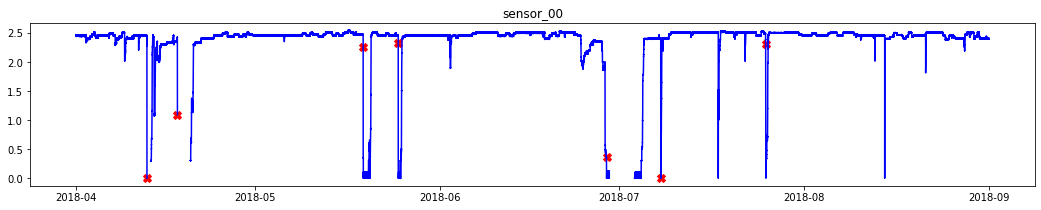

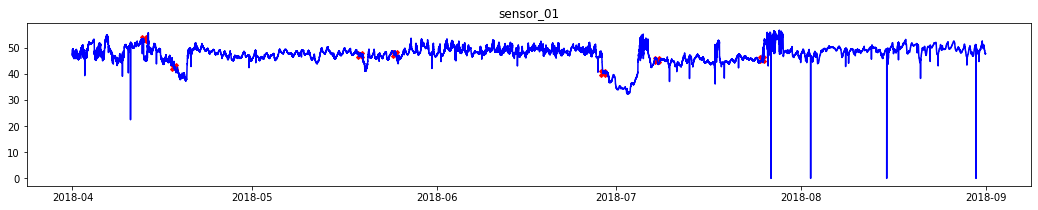

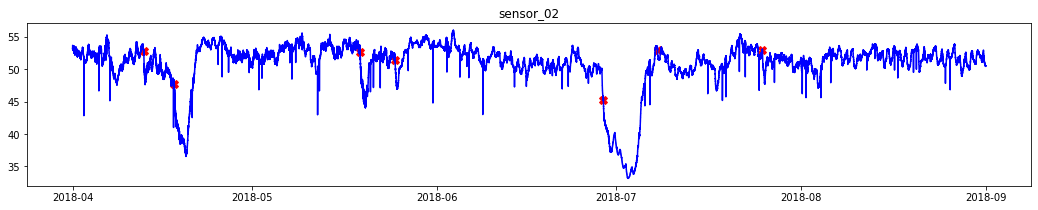

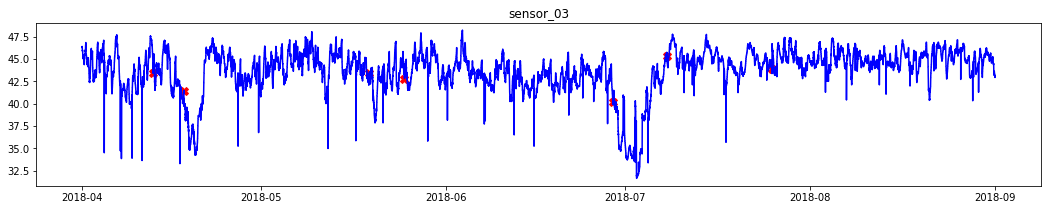

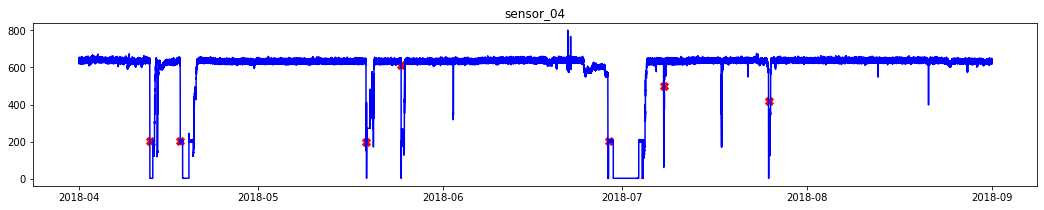

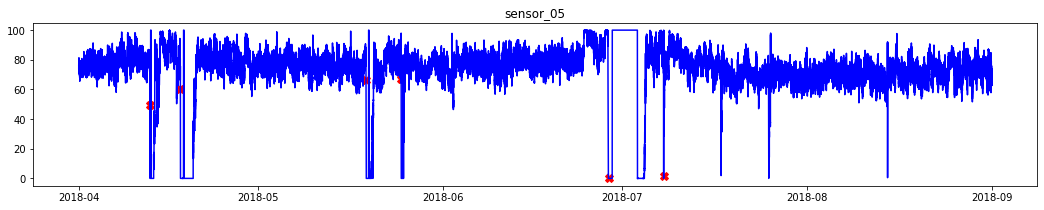

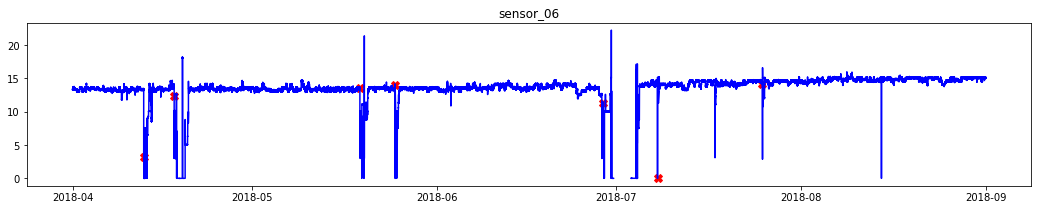

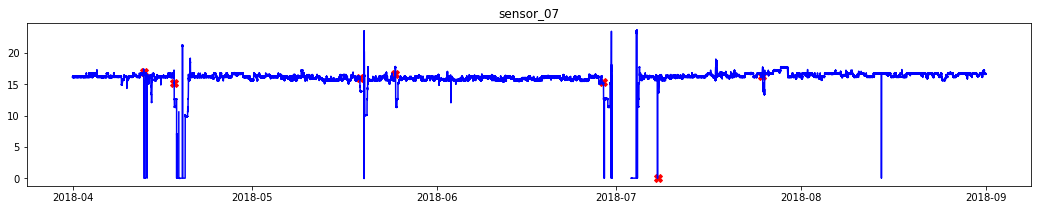

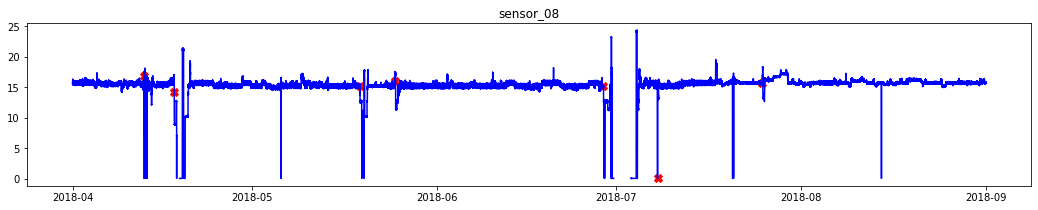

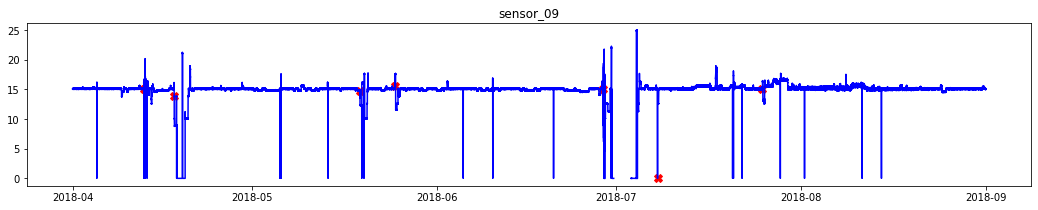

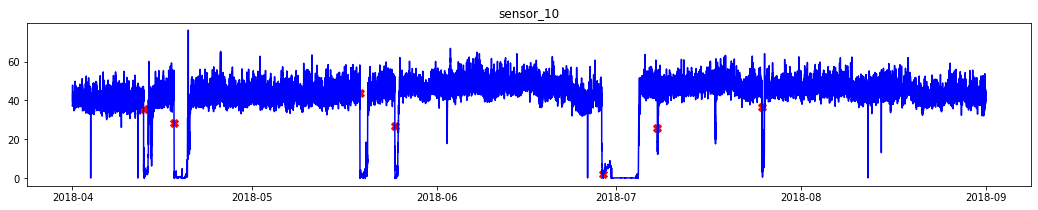

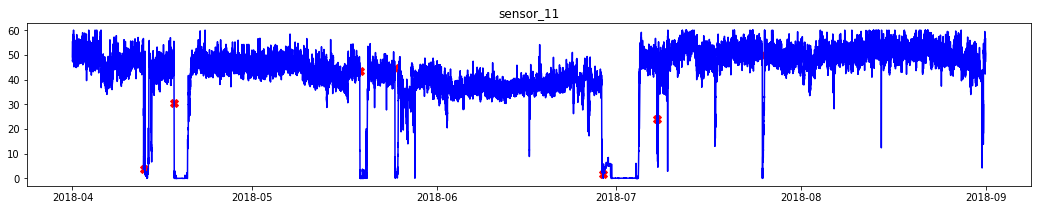

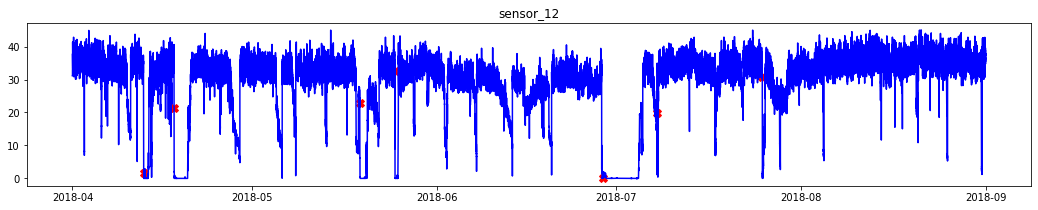

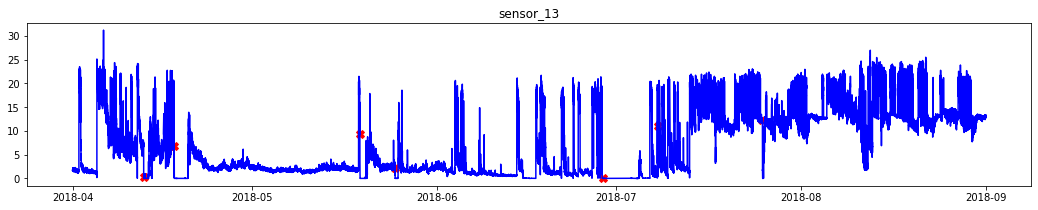

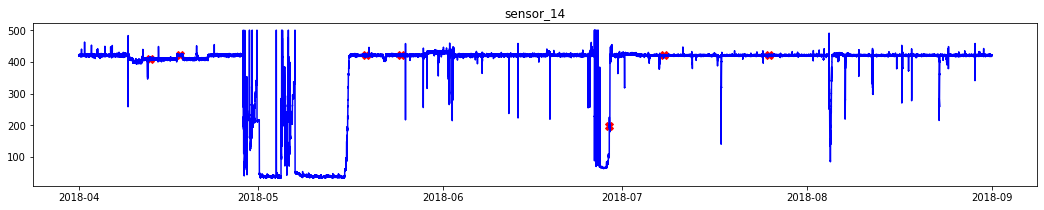

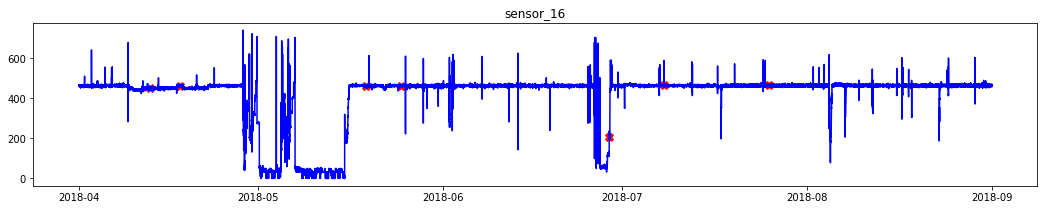

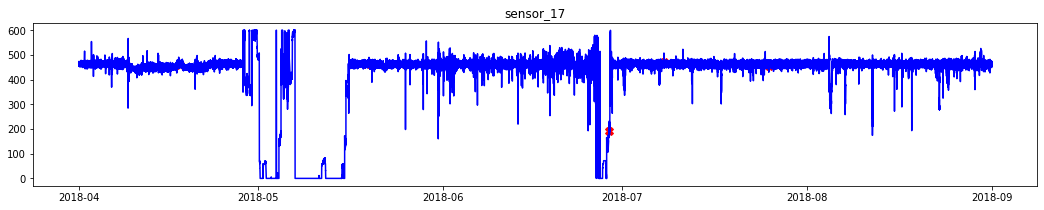

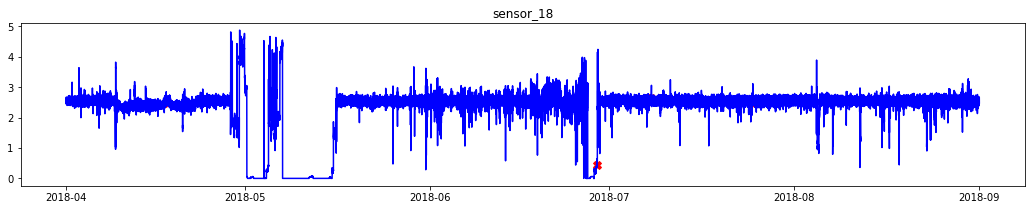

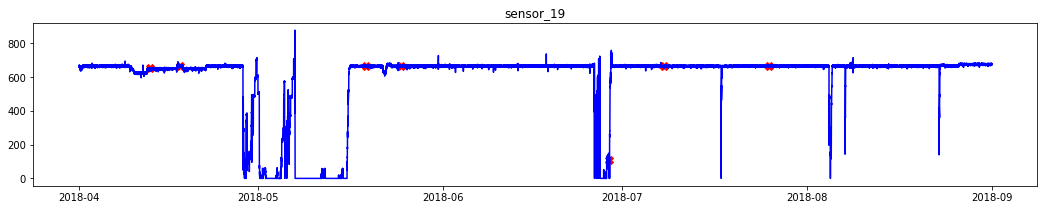

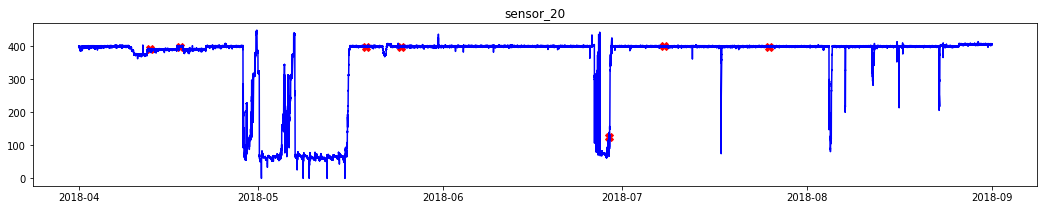

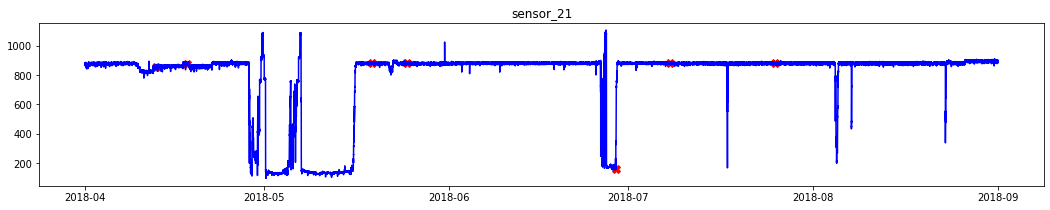

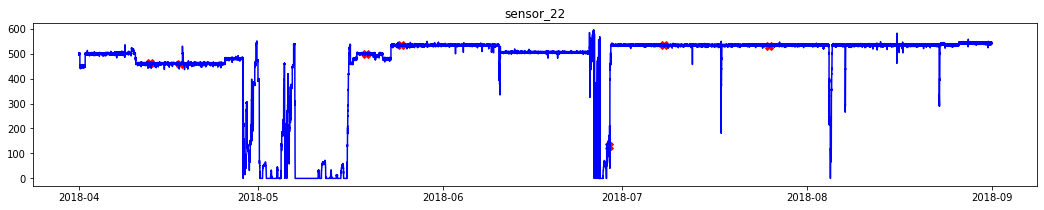

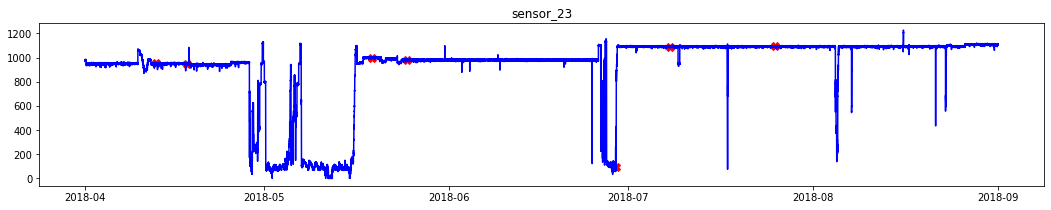

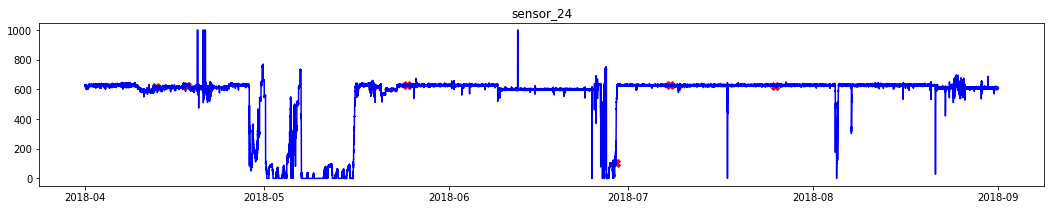

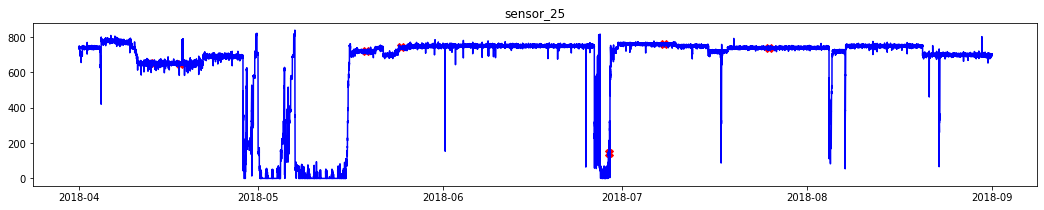

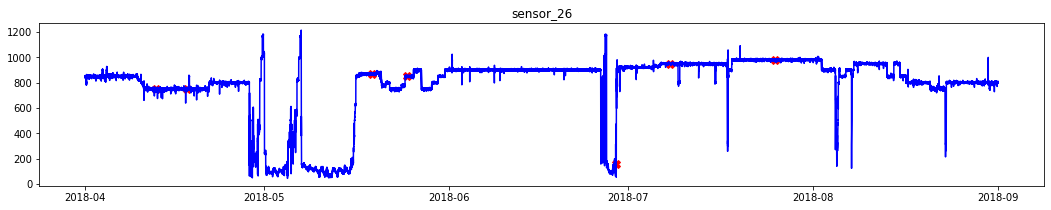

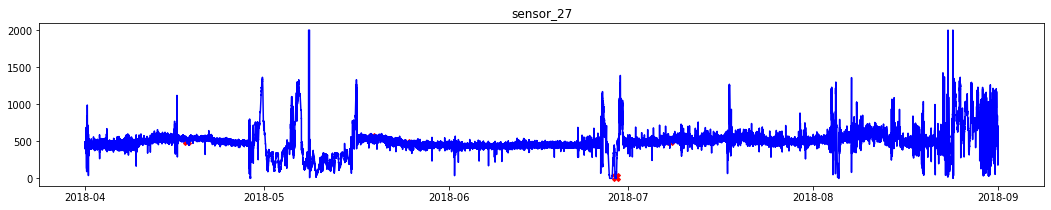

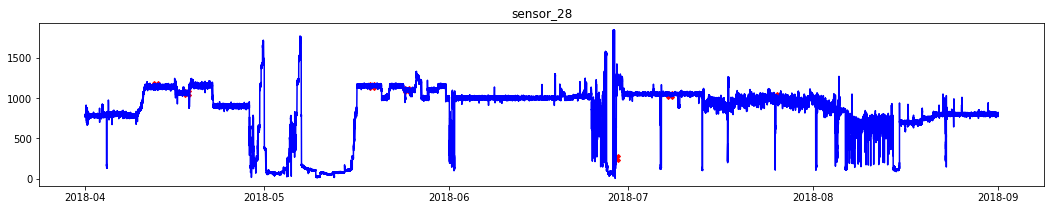

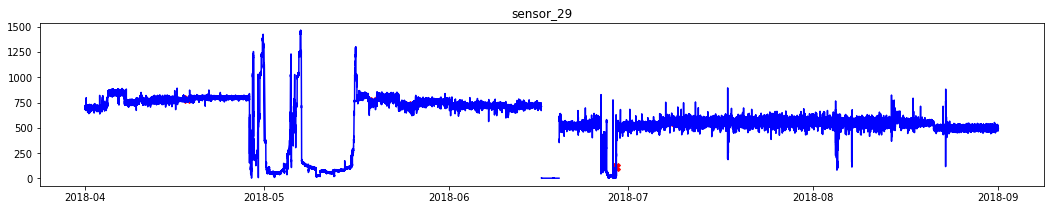

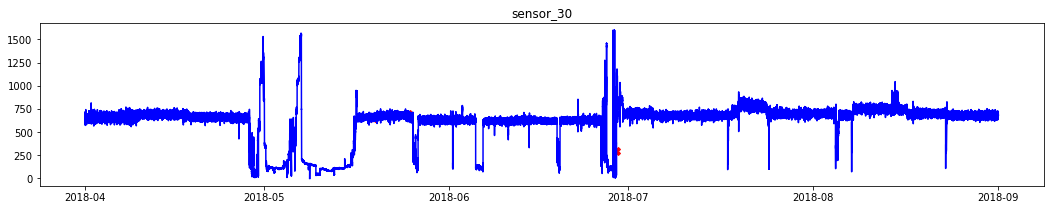

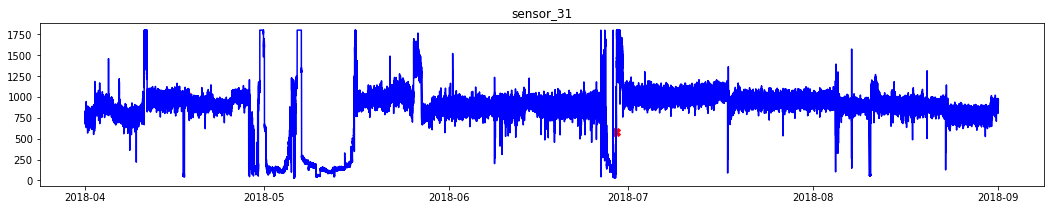

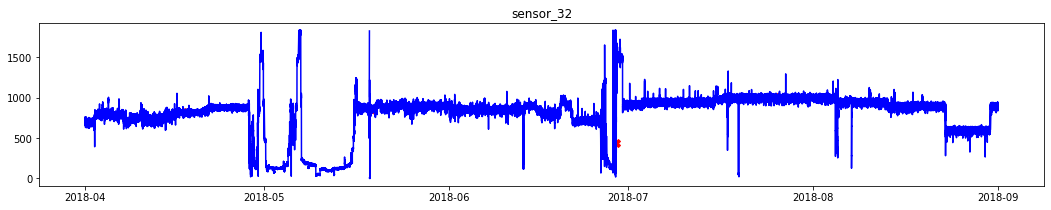

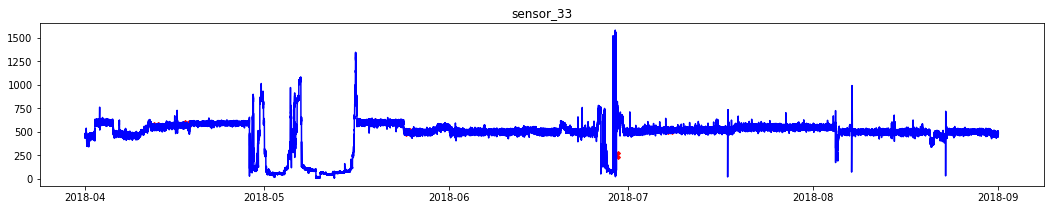

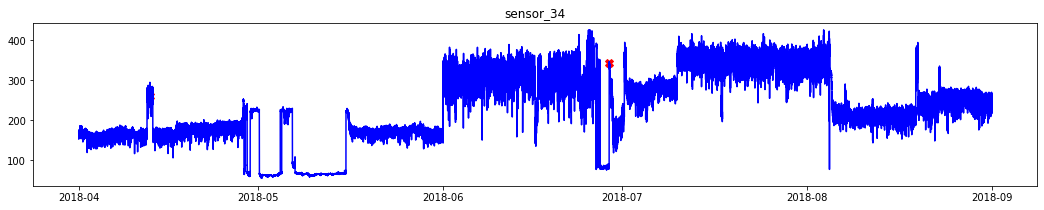

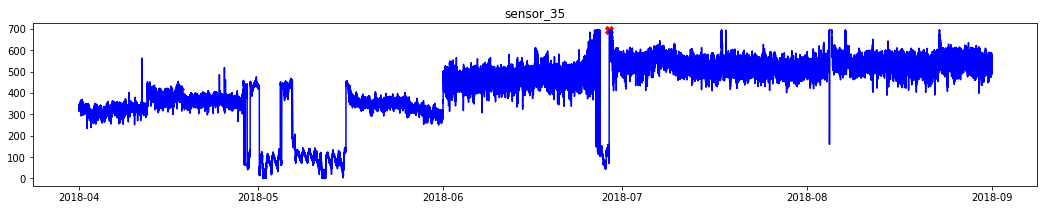

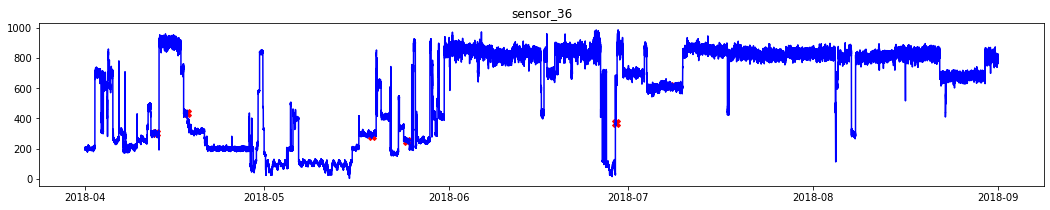

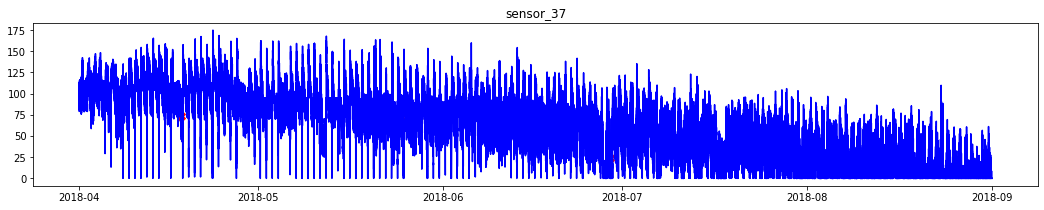

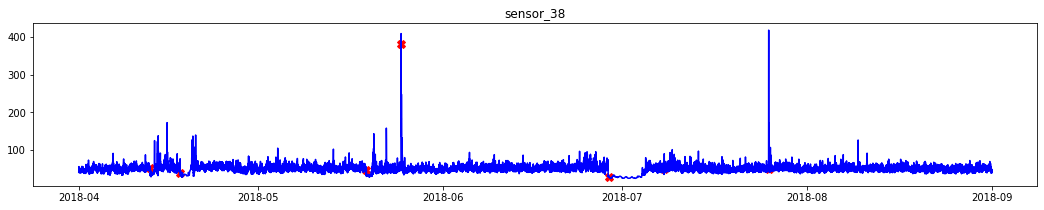

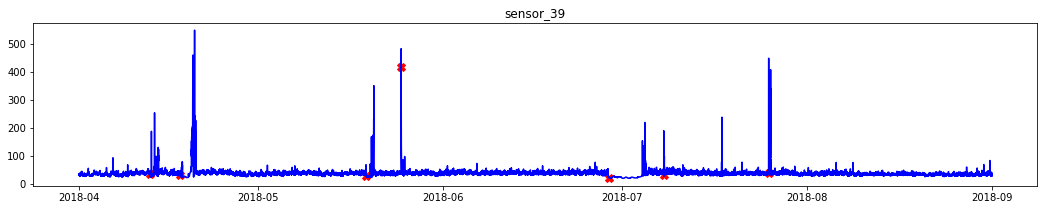

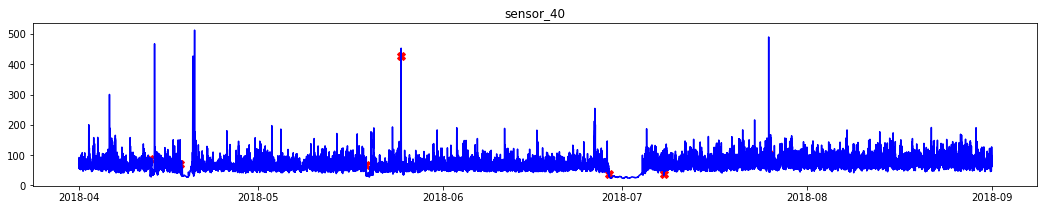

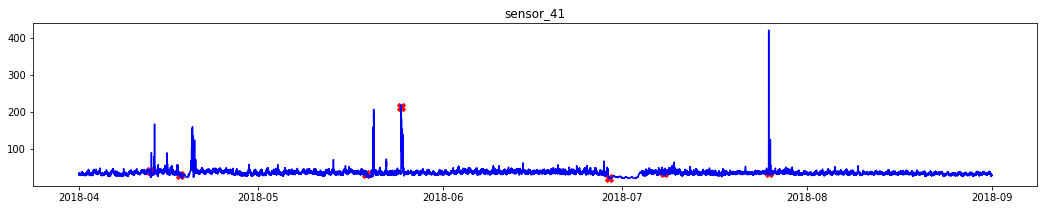

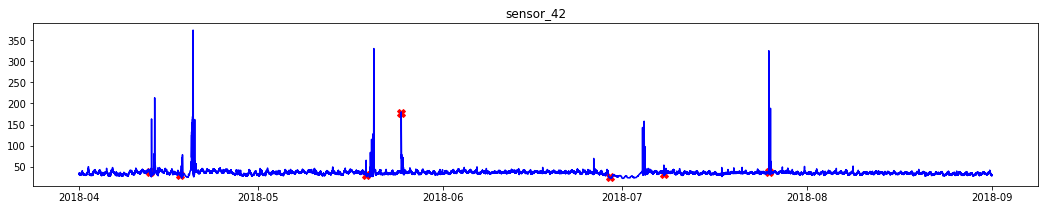

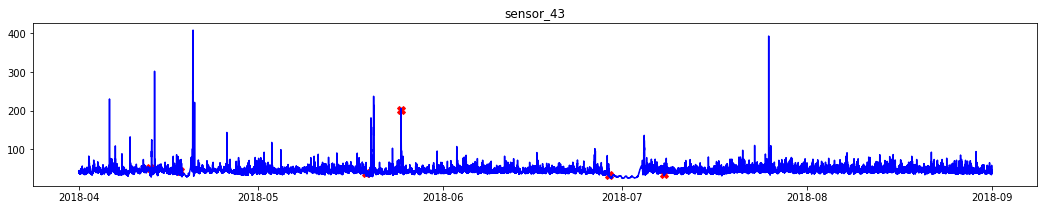

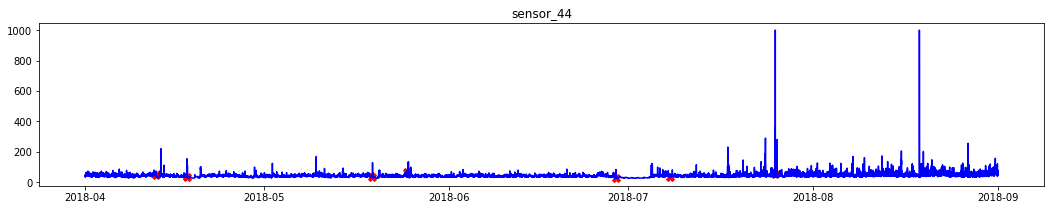

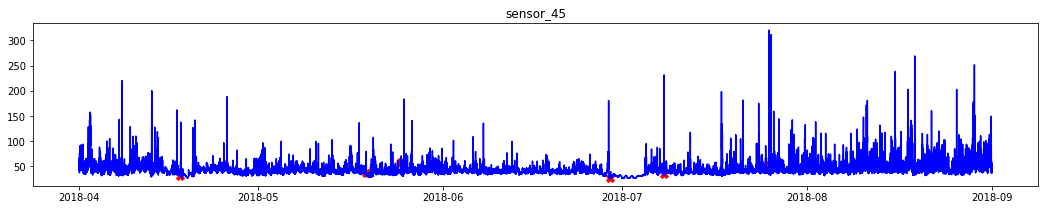

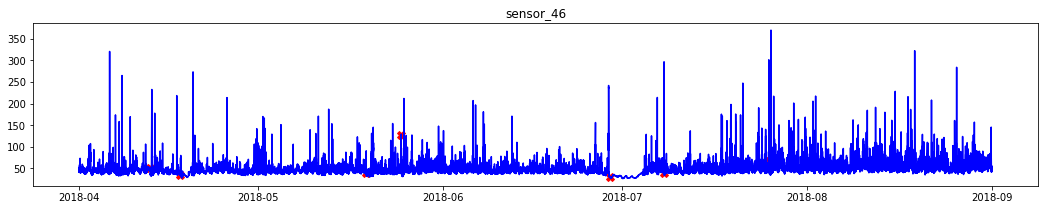

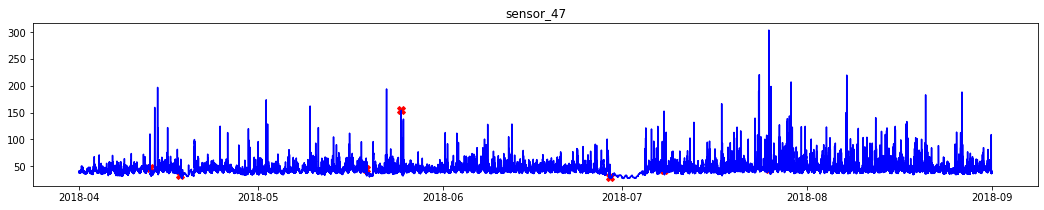

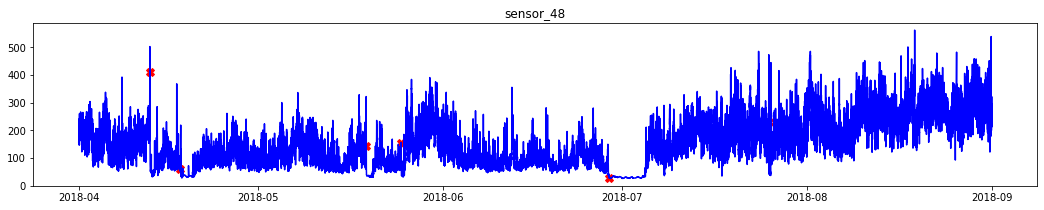

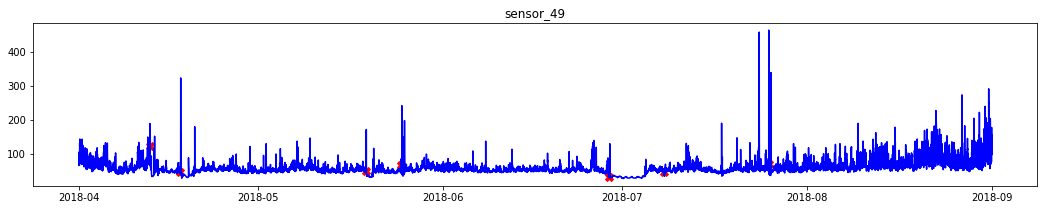

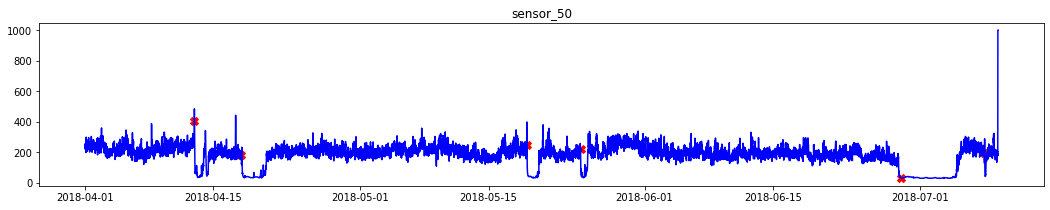

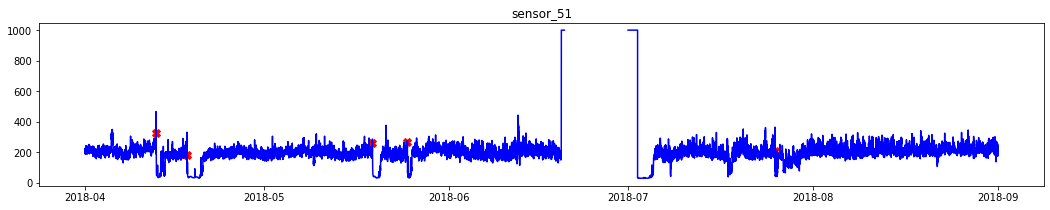

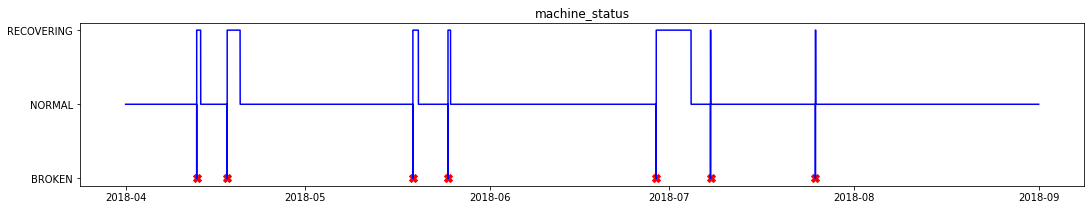

In [31]:
# Plot time series for each sensor with BROKEN state marked with X in red color
for name in names:
    _ = plt.figure(figsize=(18,3))
    _ = plt.plot(broken[name], linestyle='none', marker='X', color='red', markersize=8)
    _ = plt.plot(df[name], color='blue')
    _ = plt.title(name)
    plt.show()

As seen clearly from the above plot, the red marks, which represent the broken state of the pump, perfectly overlaps with the observed disturbances of the sensor reading. Now we have a pretty good intuition about how each of the snesor reading behaves when the pump is broken vs. operating normally.

## Stationarity and Autocorrelation

**In time series analysis, it is important that the data is stationary and have no autocorrelation.** Stationarity refers to the behavior where the mean and standard deviation of the data changes over time, the data with such behavior is considered not stationary. On the other hand, autocorrelation refers to the behavior of the data where the data is correlated with itself in a different time period. As the next step, we will visually inspect the stationarity of each feature in the dataset and the following code will do that. Later, we will also perform the Dickey Fuller test to quantitatively verity the observed stationarity. In addtion, we will inspect the autocorrelation of the features before fedding them into the clustering algorithms to detect anomalies.

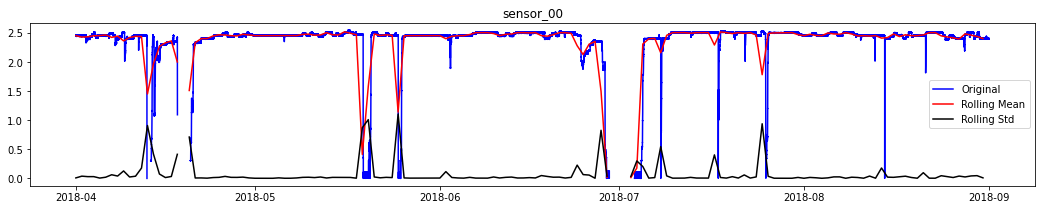

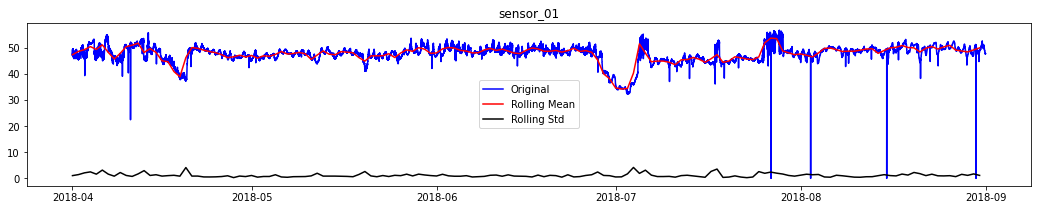

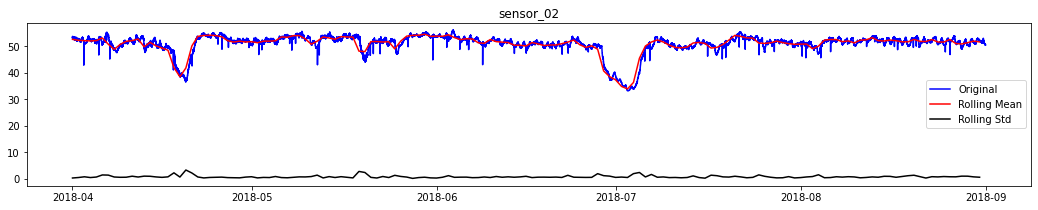

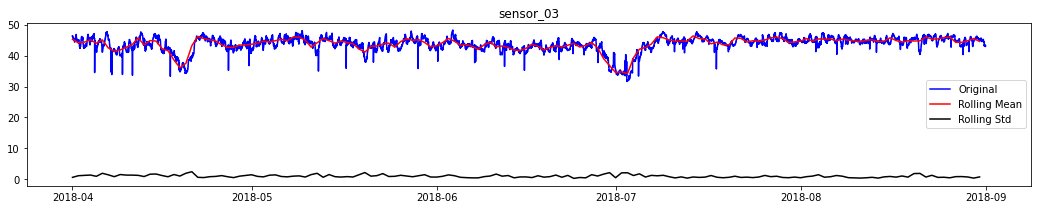

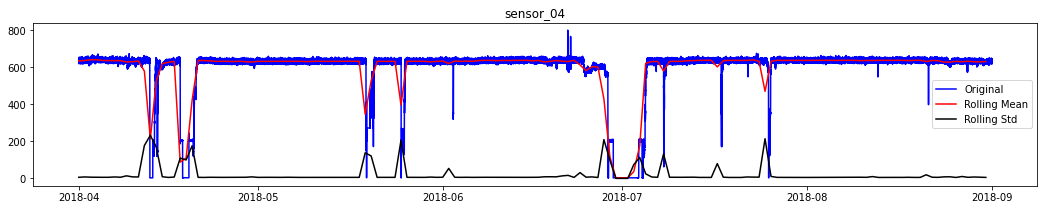

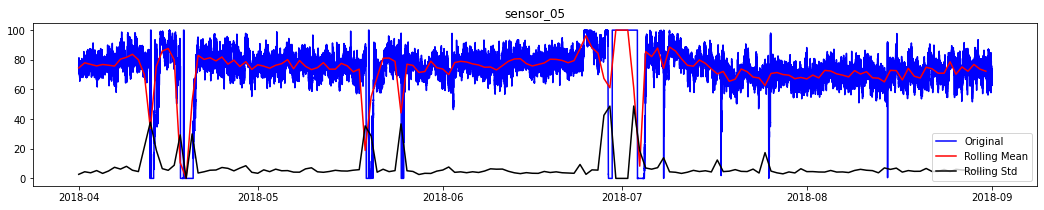

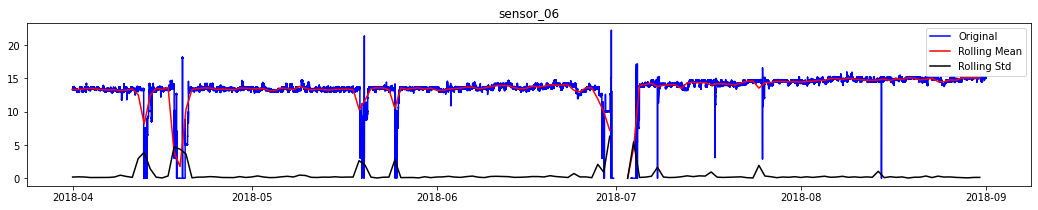

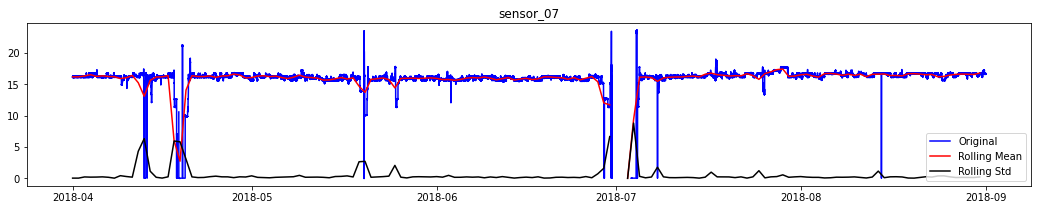

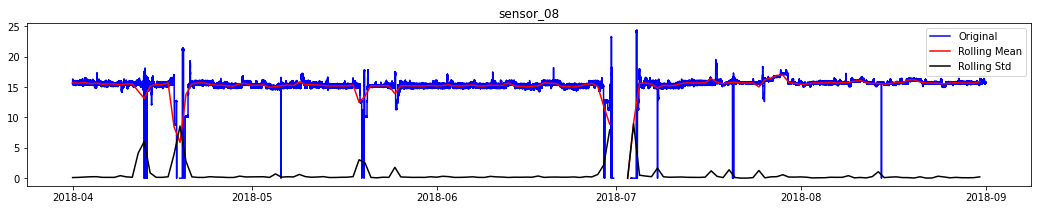

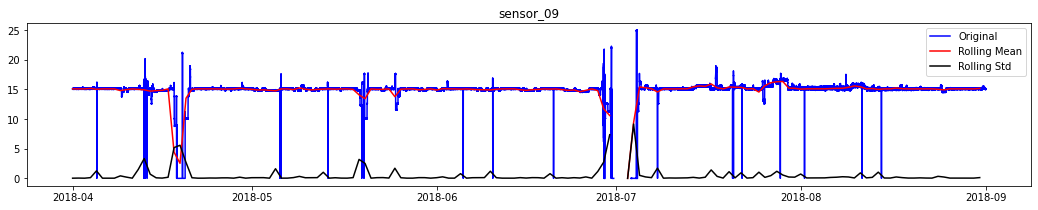

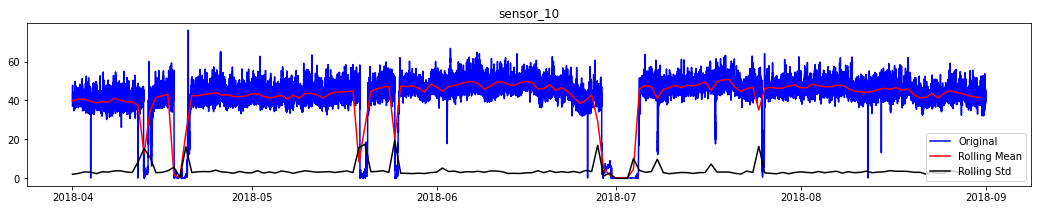

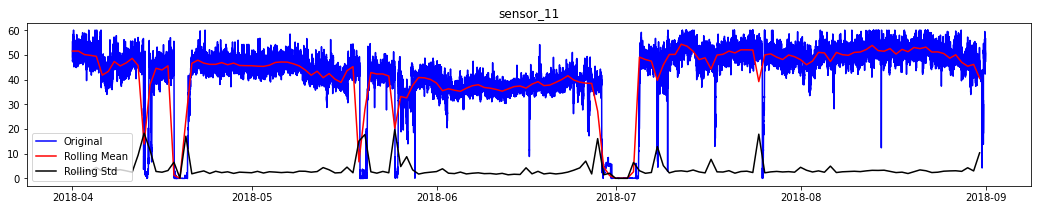

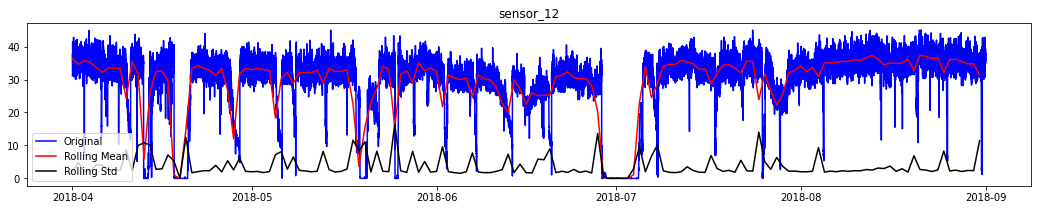

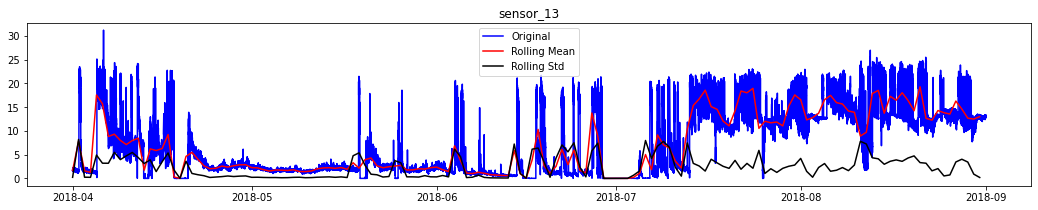

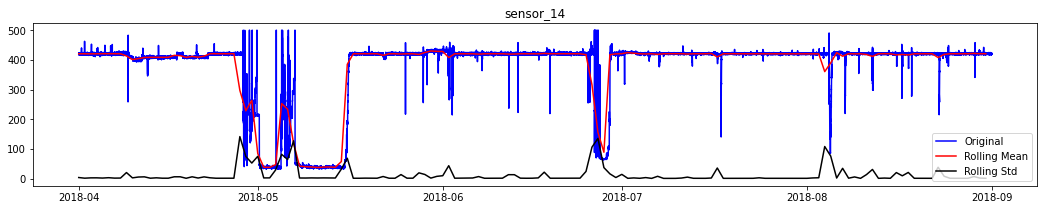

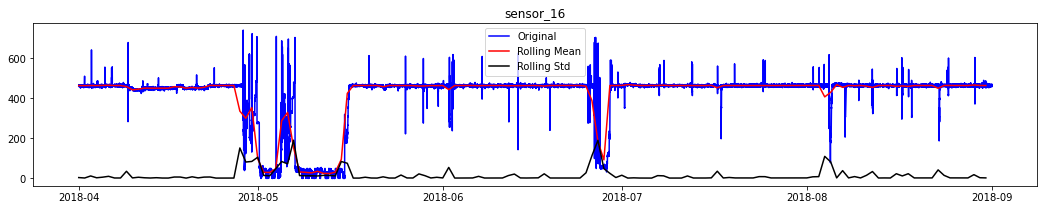

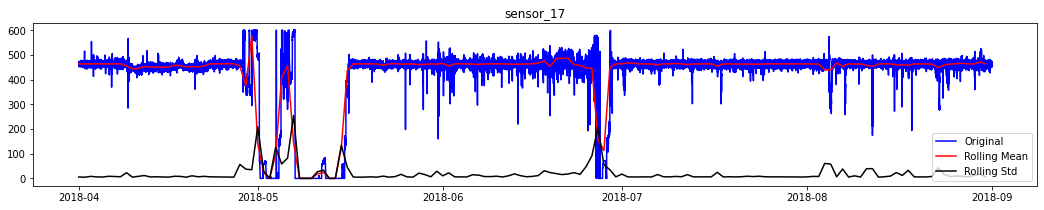

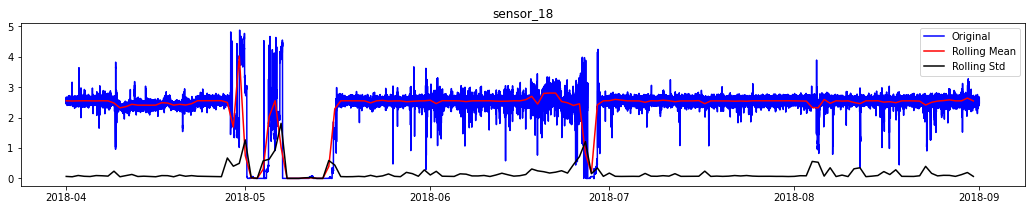

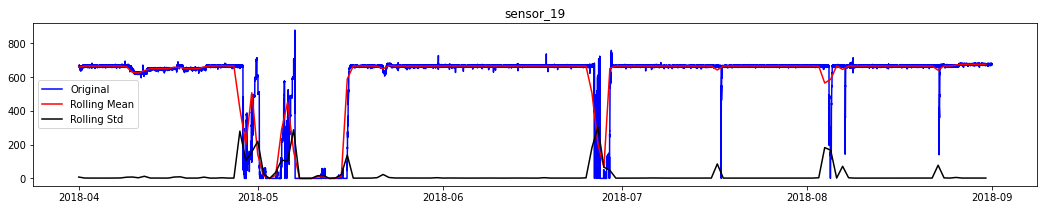

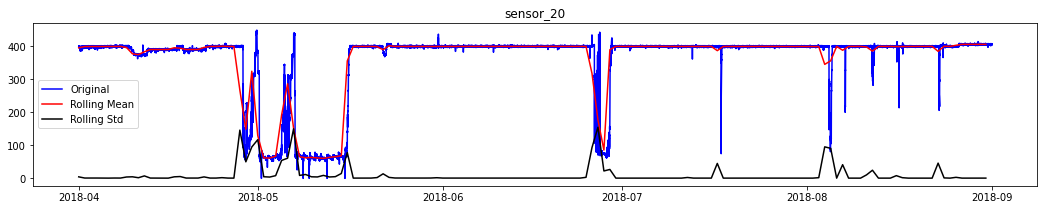

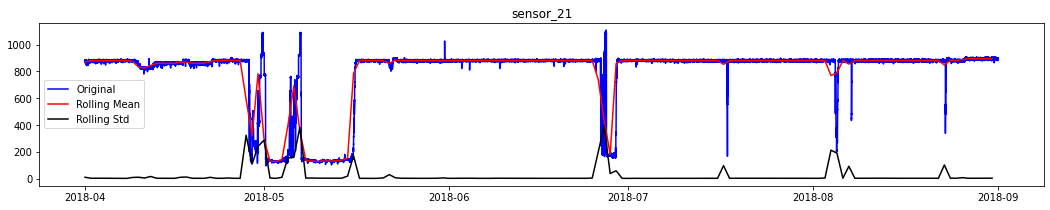

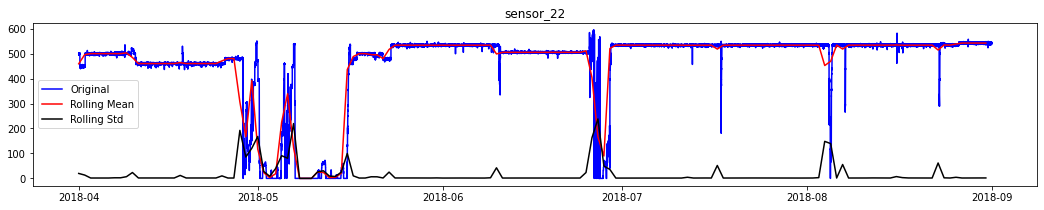

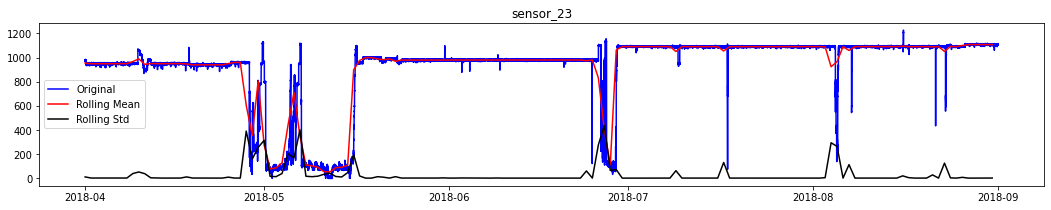

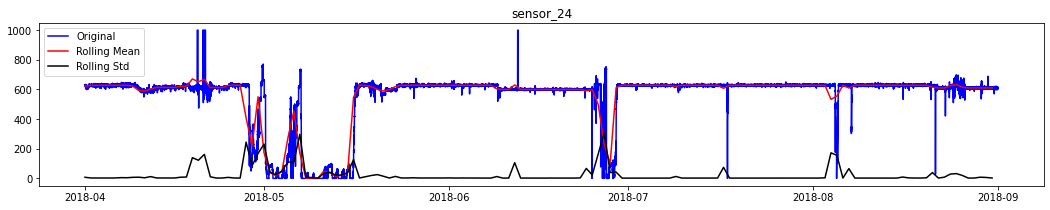

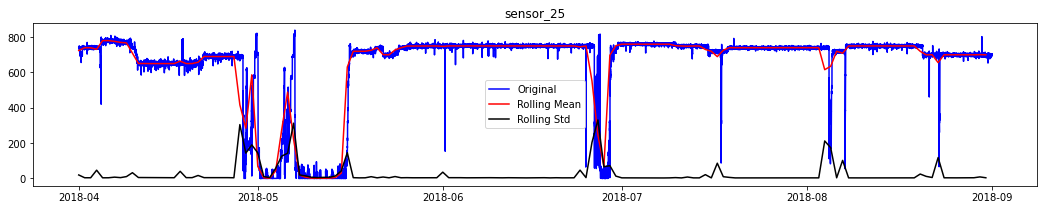

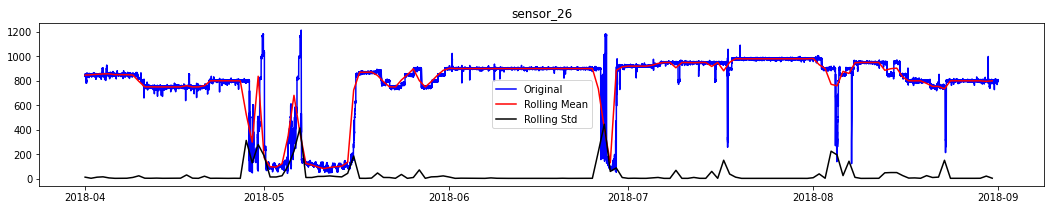

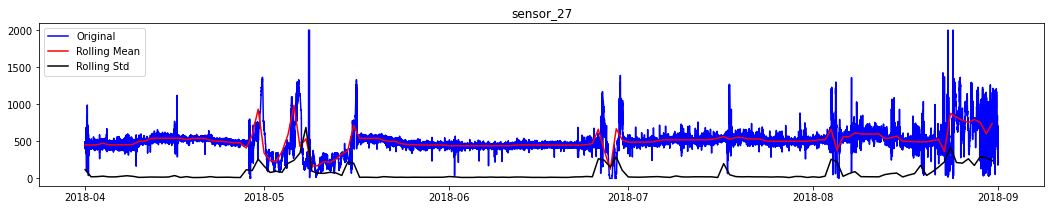

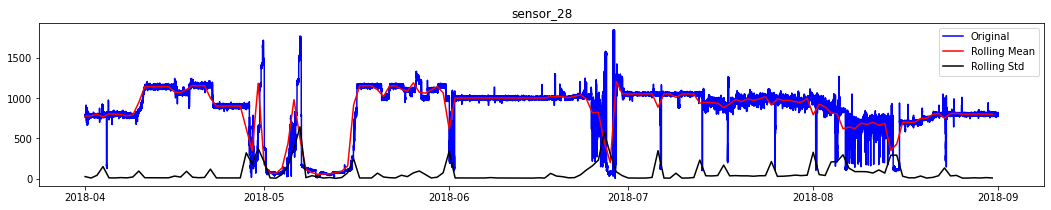

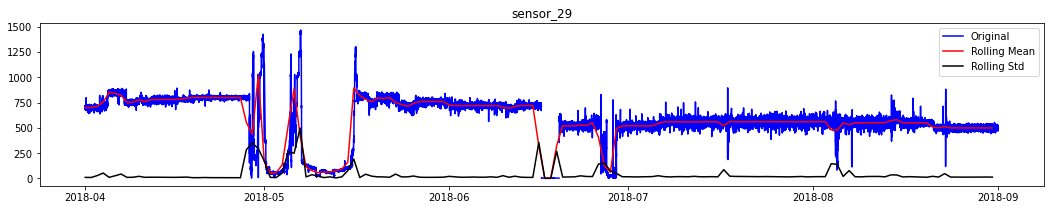

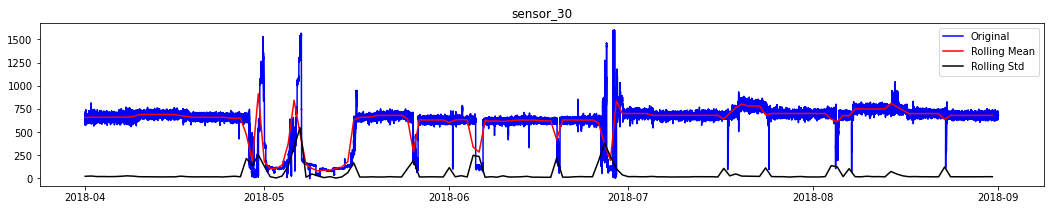

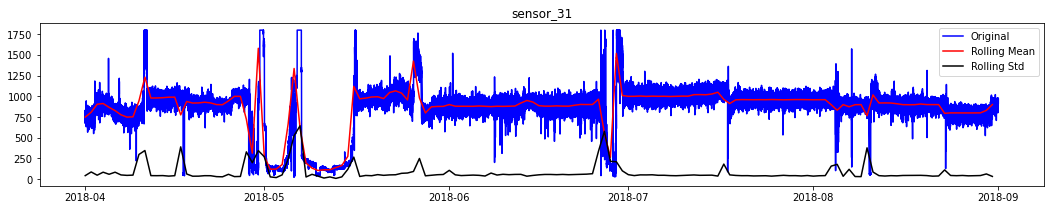

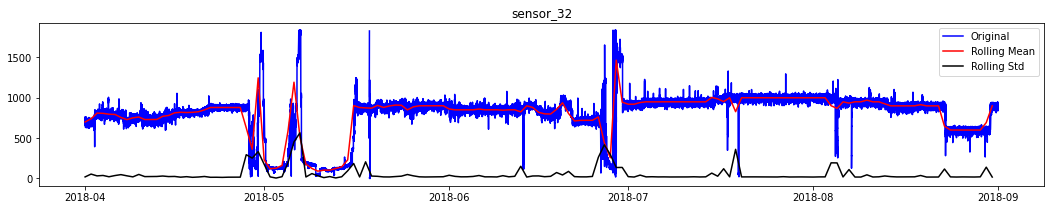

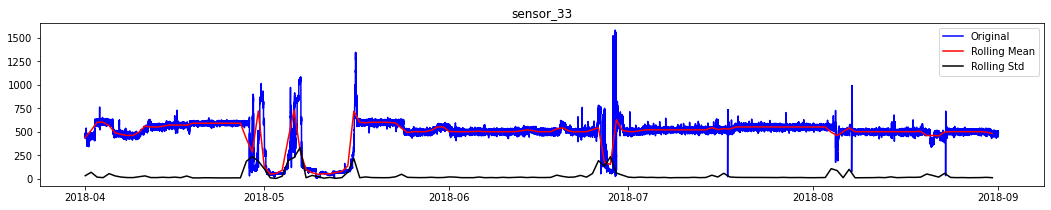

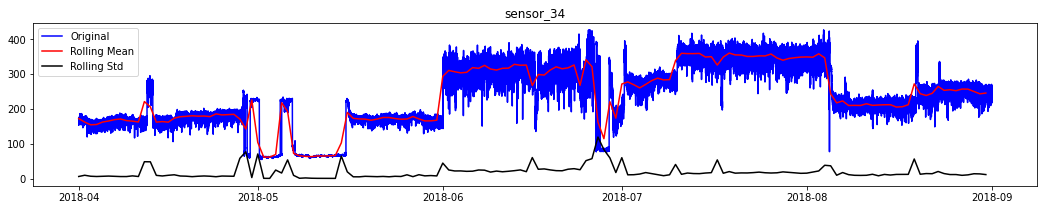

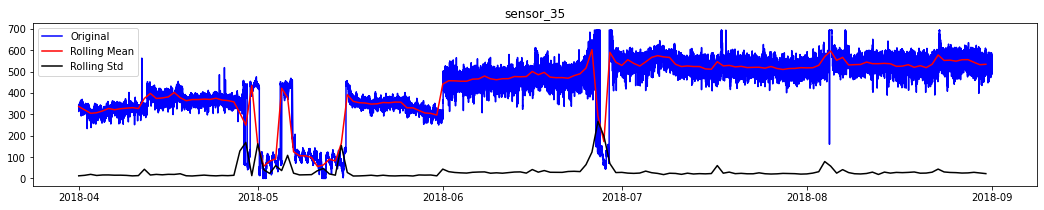

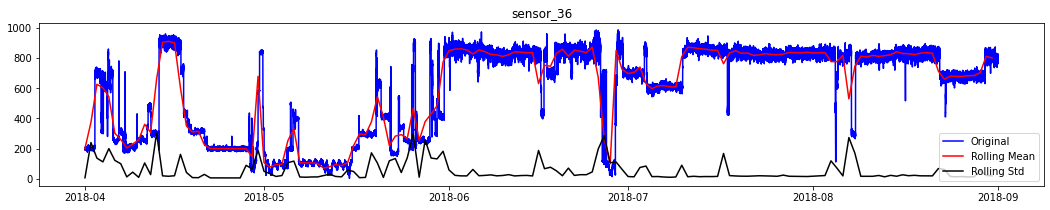

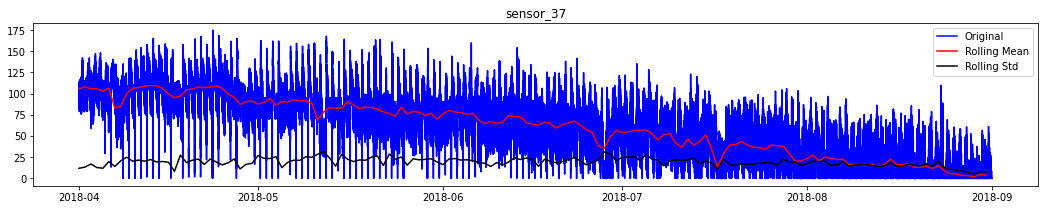

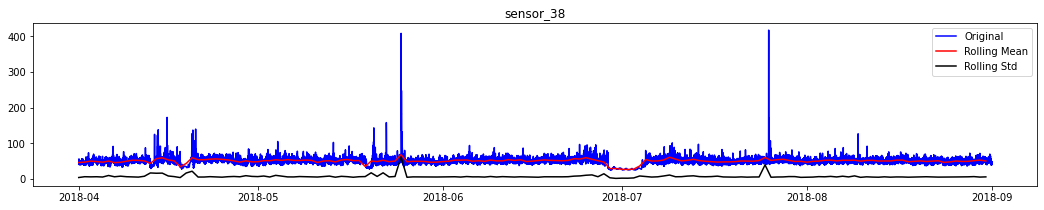

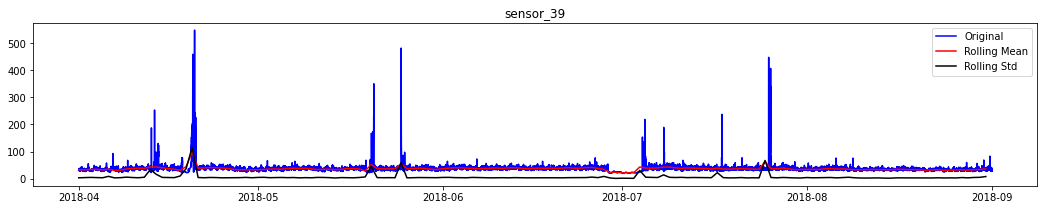

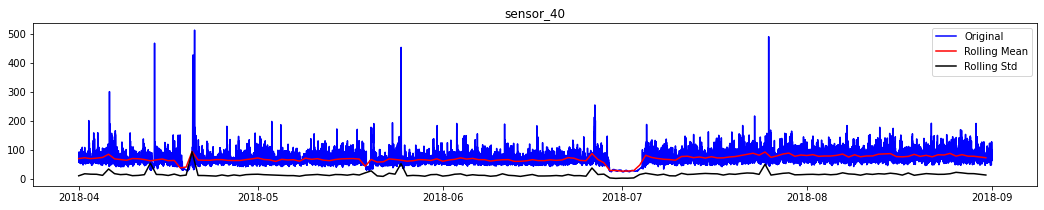

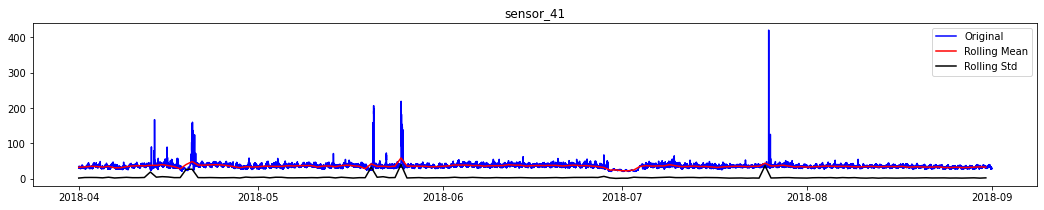

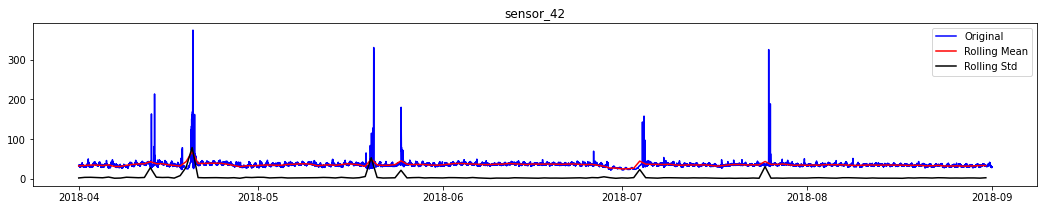

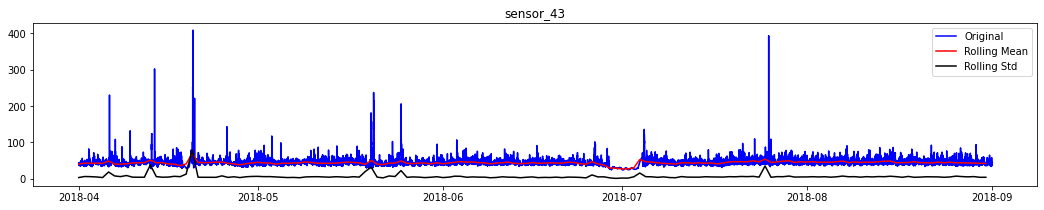

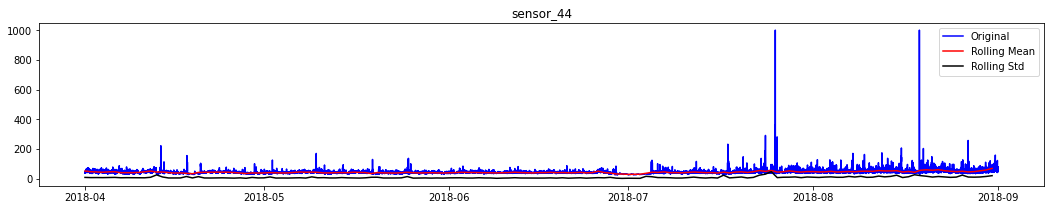

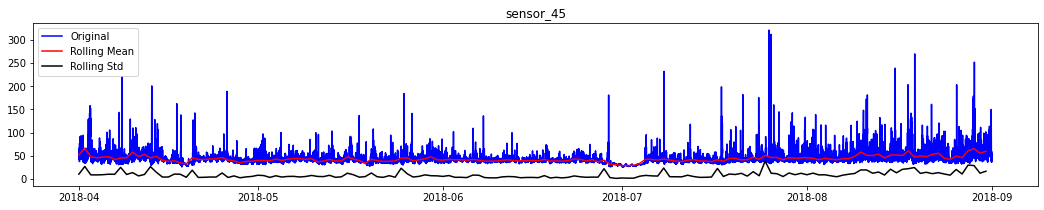

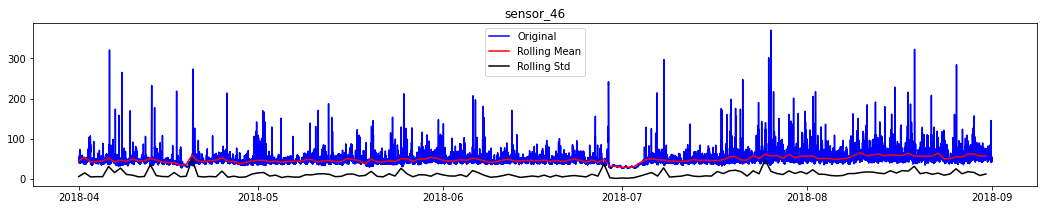

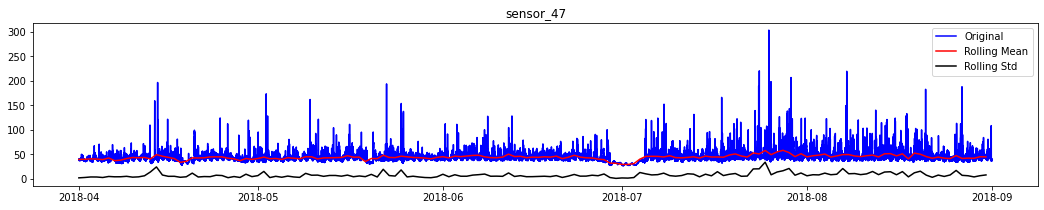

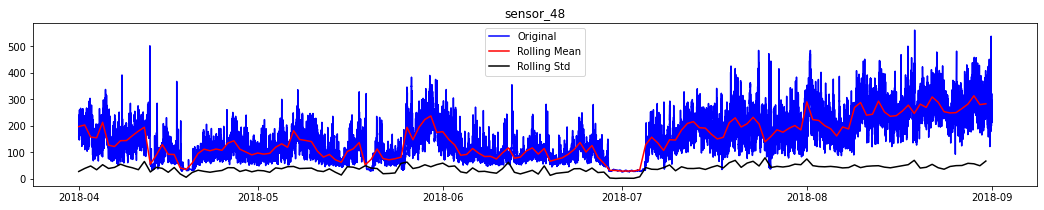

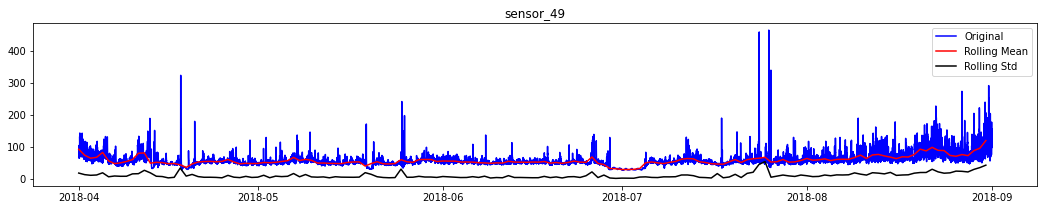

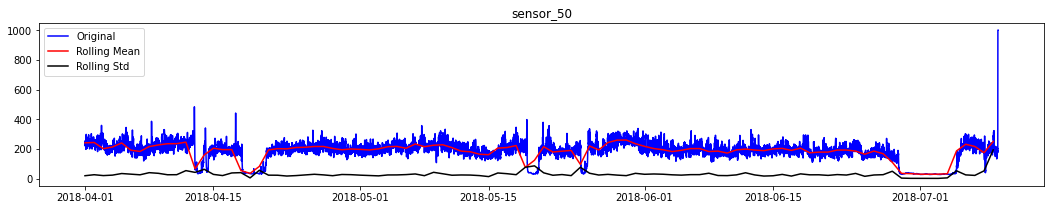

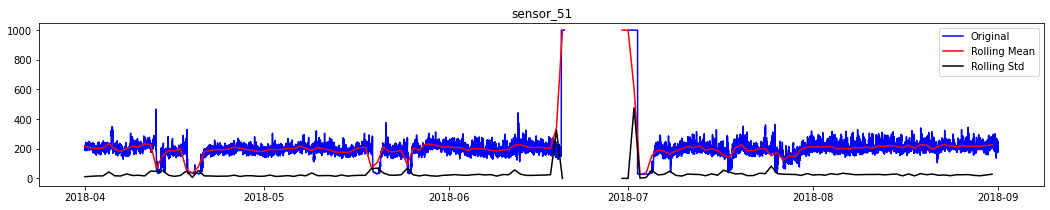

KeyError: 'machine_status'

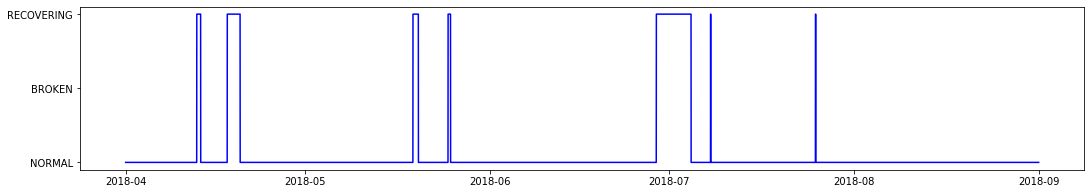

In [32]:
# Resample the entire dataset by daily average
rollmean = df.resample(rule='D').mean()
rollstd = df.resample(rule='D').std()

# Plot time-series for each sensor with its mean and standard deviation
for name in names:
    _ = plt.figure(figsize=(18,3))
    _ = plt.plot(df[name], color='blue', label='Original')
    _ = plt.plot(rollmean[name], color='red', label='Rolling Mean')
    _ = plt.plot(rollstd[name], color='black', label='Rolling Std')
    _ = plt.legend(loc='best')
    _ = plt.title(name)
    plt.show()

Looking at the readings from one of the sensors, 'sensor_17' in this case, notice that the data actually looks pretty stationary where the rolling mean and standard deviation don't seem to change over time except during the downtime of the pump that is expected. This was the case for most of the sensors in this dataset but it may not always be the case in which situations various transformation methods must be applied to make the data stationary before training the data.

## Pre-Processing and Dimensionality Reduction

It is pretty computationally expensive to train models with all of the 51 sensors/features and it is not efficient. Therefore, we will employ Principal Component Analysis (PCA) technique to extract new features to be used for the modeling. To properly apply PCA, the data must be scaled and standardized because PCA and most of the learning algorithms are distance-based algorithms. If noticed from the first 10 rows of the dity data, the magnitude of the values from each feature is not consistent. We will perform the following steps using the Pipeline library.
1. Scale the data
2. Perform PCA and look at the most important principal components based on inertia

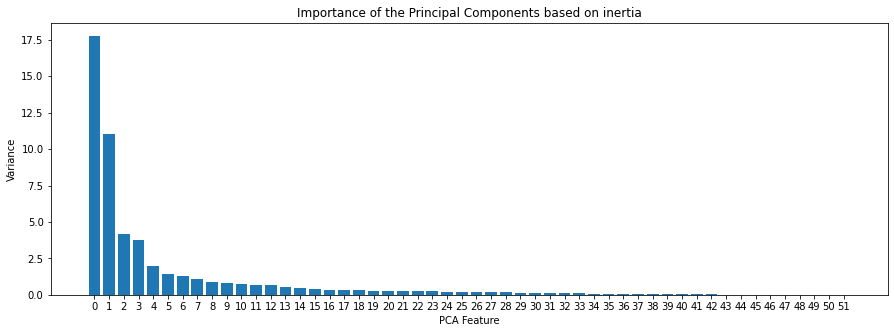

In [33]:
# Standardize/scale the dataset and apply PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

# Extract the names of the numerical columns
df2 = df.drop(['machine_status'], axis=1)
# Replace all NaNs with zeros
df2 = df2.replace(np.nan, 0, regex=True)
names = df2.columns
x = df2[names]

scaler = StandardScaler()
pca = PCA()
pipeline = make_pipeline(scaler, pca)
pipeline.fit(x)

# Plot the principal components against their inertia
features = range(pca.n_components_)
_ = plt.figure(figsize=(15, 5))
_ = plt.bar(features, pca.explained_variance_)
_ = plt.xlabel('PCA Feature')
_ = plt.ylabel('Variance')
_ = plt.xticks(features)
_ = plt.title("Importance of the Principal Components based on inertia")
plt.show()

It appears that the first two principal components are the most important as per the features extracted by the PCA in above importance plot. As the next step, we will perform PCA with two components that will be my features to be used in the training of the models.

In [59]:
# Calculate PCA with two components
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns=['pc1', 'pc2'])
print(principalDf)

                  pc1         pc2
0      -110159.238209 -363.627835
1      -110158.238223 -363.624117
2      -110157.100634 -406.192119
3      -110156.080814 -409.432118
4      -110155.156521 -405.596303
...               ...         ...
220315  110156.382425  128.960943
220316  110157.242193  140.660537
220317  110158.279280  135.409941
220318  110159.243619  151.073673
220319  110160.293268  138.037955

[220320 rows x 2 columns]


Now, we will check again the stationarity and autocorrelation of these two principal components to be sure that they are stationary and not autocorrelated.

In [35]:
from statsmodels.tsa.stattools import adfuller

# Run Augmented Dickey Fuller Test
result = adfuller(principalDf['pc2'])

# Print p-value
print(result[1])

4.698891143213911e-06


Running the Dickey Fuller test on the 1st principal component, we got a p-value of 0.9634 that is very small number *(?.. not sure why different number comes out compared to reference website)*

Now, let us check for autocorrelation in both of these prinicipal components. It can be done one of the two ways; either with the pandas `autocorr()` method or `ACF plot`. We will use the latter in this case to quickly visually verify that there is no autocorrelation. The following code does that:

In [60]:
# Plot ACF
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(pc1.dropna(), lags=20, alpha=0.05) # something in code is missing in reference

NameError: name 'pc1' is not defined

## Modeling

In this step, we will perform the following learning algorithms to detect anomalies.
1. Benchmark model: Interquartile Range (IQR)
2. K-Means clustring
Let us start training with these algorithms.

### 1. Interquartile Range

Strategy:
1. Calculate IQR that is the difference between 75th (Q3) AND 25th (Q1) percentiles.
2. Calculate upper and lower bounds for the outlier.
3. Filter the data points that fall outside the upper and lower bounds and flag them as outliers.
4. Finally, plot the outliers on top of the time-series data (the readings from 'sensor_11' in this case)

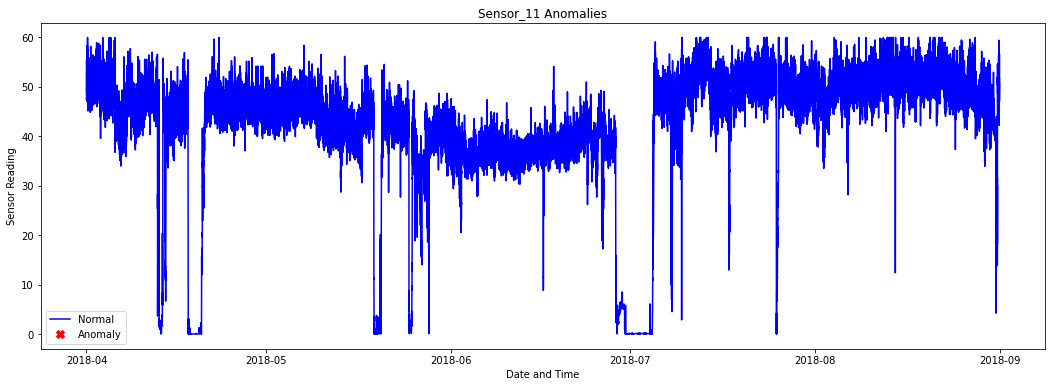

Series([], Name: sensor_11, dtype: float64)


In [58]:
## for pc1
# Calculate IQR for the 1st principal component (pc1)
q1_pc1, q3_pc1 = principalDf['pc1'].quantile([0.25, 0.75])
iqr_pc1 = q3_pc1 - q1_pc1

# Calculate upper and lower bounds for outlier for pc1
lower_pc1 = q1_pc1 - 1.5*iqr_pc1
upper_pc1 = q3_pc1 + 1.5*iqr_pc1

# Filter out the outliers from the pc1
principalDf['anomaly_pc1'] = ((principalDf['pc1']>upper_pc1) | (principalDf['pc1']<lower_pc1)).astype('int')

## for pc2
# Calculate IQR for the 2nd principal component (pc2)
q1_pc2, q3_pc2 = principalDf['pc2'].quantile([0.25, 0.75])
iqr_pc2 = q3_pc2 - q1_pc2

# Calculate upper and lower bounds for outlier for pc1
lower_pc2 = q1_pc2 - 1.5*iqr_pc2
upper_pc2 = q3_pc2 + 1.5*iqr_pc2

# Filter out the outliers from the pc2
principalDf['anomaly_pc2'] = ((principalDf['pc2']>upper_pc2) | (principalDf['pc2']<lower_pc2)).astype('int')

# Plot the outliers from pc1 on top of the 'sensor_11' and see where they occured in the time-series
df['anomaly_pc1'] = pd.Series(principalDf['anomaly_pc1'].values, index=df.index)
a = df.loc[df['anomaly_pc1'] == 1] # anomaly
_ = plt.figure(figsize=(18,6))
_ = plt.plot(df['sensor_11'], color='blue', label='Normal')
_ = plt.plot(a['sensor_11'], linestyle='none', marker='X', color='red', markersize=8, label='Anomaly')
_ = plt.xlabel('Date and Time')
_ = plt.ylabel('Sensor Reading')
_ = plt.title('Sensor_11 Anomalies')
_ = plt.legend(loc='best')
plt.show();


### 2. K-Means Clustering

Strategy:
1. Calculate the distance between each point and its nearest centroid. The biggest distances are considered as anomaly.
2. We use `outliers_fraction` to provide information to the algorithm about proportion of the outliers present in our datset. Situations may vary from dataset to dataset. However, as a starting figure, the author estimate outliers_fraction=0.13 (13% of df are outliers as depicted).
3. Calculate `number_of_outliers` using `outliers_fraction`.
4. Set threshold as the minimum distance of these outliers.
5. The anomaly result of `anomaly1` constains the above method Cluster (0: normal, 1: anomaly).
6. Visualize anomalies with Time Series view.

In [55]:
# Import necessary libraries
from sklearn.cluster import KMeans

# Will start k-means clustering with k=2 as we already know that there are 3 classes of 'NORMAL' vs. 
# "NOT NORMAL" which are combination of 'BROKEN' and 'RECOVERING'
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(principalDf.values)
labels = kmeans.predict(principalDf.values)
unique_elements, counts_elements = np.unique(labels, return_counts=True)
clusters = np.asarray((unique_elements, counts_elements))

# Write a function that calculates distance between each point and the centroid of the closest cluster
def getDistanceByPoint(data, model):
    """ Function that calculates the distance between a point and centroid of a cluster, 
            returns the distances in pandas series"""
    distance = []
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.append(np.linalg.norm(Xa-Xb))
    return pd.Series(distance, index=data.index)

# Assume that 13% of the entire data set are anomalies 
outliers_fraction = 0.13

# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(principalDf, kmeans)

# number of observations that equate to the 13% of the entire data set
number_of_outliers = int(outliers_fraction*len(distance))

# Take the minimum of the largest 13% of the distances as the threshold
threshold = distance.nlargest(number_of_outliers).min()

# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
principalDf['anomaly1'] = (distance >= threshold).astype(int)

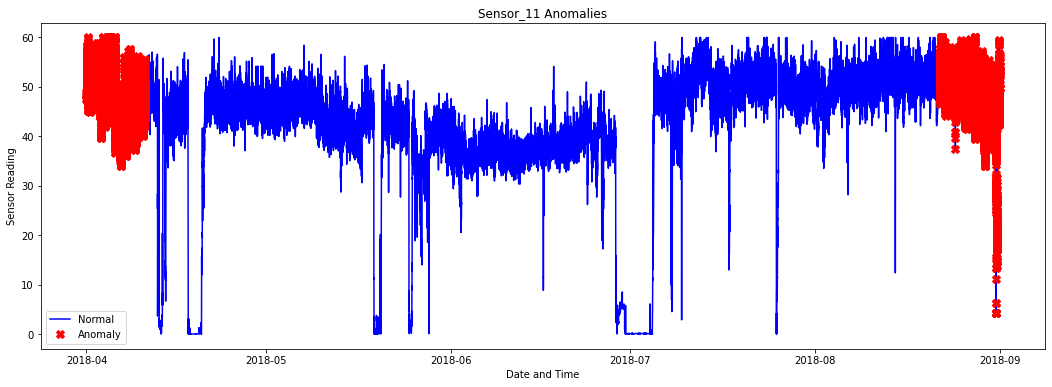

In [56]:
# Plot the outliers from anomaly1 on top of the 'sensor_11' and see where they occured in the time-series
df['anomaly1'] = pd.Series(principalDf['anomaly1'].values, index=df.index)
b = df.loc[df['anomaly1'] == 1] # anomaly
_ = plt.figure(figsize=(18,6))
_ = plt.plot(df['sensor_11'], color='blue', label='Normal')
_ = plt.plot(b['sensor_11'], linestyle='none', marker='X', color='red', markersize=8, label='Anomaly')
_ = plt.xlabel('Date and Time')
_ = plt.ylabel('Sensor Reading')
_ = plt.title('Sensor_11 Anomalies')
_ = plt.legend(loc='best')
plt.show();

## Conclusion

We have done anomaly detection with two different methods. In doing so, we went through most of the steps of the commonly applied Data Science Process which incldues the following steps:
1. Problem identification
2. Data wrangling
3. Exploratory data analysis
4. Pre-processing and training data development
5. Modeling